This notebook aims to analyze the training results of JAX-CanVeg.

In [1]:
import itertools
from pathlib import Path

import numpy as np
import pandas as pd

from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.gridspec import GridSpec

%matplotlib inline 

In [2]:
# Plotting parameters
# rc('text', usetex=False)
small_size = 15
medium_size = 25
bigger_size = 30
plt.rc('font', size=small_size)          # controls default text sizes
plt.rc('axes', titlesize=small_size)    # fontsize of the axes title
plt.rc('axes', labelsize=small_size)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=small_size)    # fontsize of the tick labels
plt.rc('ytick', labelsize=small_size)    # fontsize of the tick labels
plt.rc('legend', fontsize=small_size)    # legend fontsize
plt.rc('figure', titlesize=small_size)  # fontsize of the figure title
plt.rc('text', usetex = False)

# Locations of files and folders

In [3]:
sites = ["US-Bi1", "US-Me2", "US-Whs", "US-Hn1"]
canopy_layers = ["1L", "ML"]
model_types = ["PB", "Hybrid"]
le_weight = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
canveg_combinations = list(
    itertools.product(sites, canopy_layers, model_types, le_weight)
)
dnn_combinations = list(itertools.product(sites, le_weight))

metrics = ["mse", "nse", "cc"]
metrics_labels = ["MSE", "NSE", "CC"]
outputs = ["LE", "NEE"]


# Load the training results

## Modeling performances

In [4]:
df_metrics = pd.DataFrame(
    columns=[
        "site",
        "model",
        "layer",
        "weight",
        "varn",
        "train_or_test",
        "rse",
        "mare",
        "rmse",
        "mse",
        "r2",
        "kge",
        "nse",
        "mkge",
        "cc",
        "alpha",
        "beta",
    ]
)
i = 0

# JAX-CanVeg
for site, cl, mt, mow in tqdm(canveg_combinations):
    dir_model = Path(site) / f"{mt}-{cl}-{mow}"
    f_metrics = dir_model / "metrics.csv"
    if not dir_model.is_dir() or not f_metrics.is_file():
        continue
    df_metrics_model = pd.read_csv(f_metrics, index_col=0)
    for index, row in df_metrics_model.iterrows():
        index = index.split("-")
        varn, train_or_test = index[0], index[1]
        df_metrics.loc[i] = [
            site,
            mt,
            cl,
            mow,
            varn,
            train_or_test,
            row["rse"],
            row["mare"],
            row["rmse"],
            row["mse"],
            row["r2"],
            row["kge"],
            row["nse"],
            row["mkge"],
            row["cc"],
            row["alpha"],
            row["beta"],
        ]
        i += 1

# DNN
for site, mow in tqdm(dnn_combinations):
    dir_model = Path(site) / f"DNN_LE-GPP-{mow}"
    f_metrics = dir_model / "metrics.csv"
    if not dir_model.is_dir() or not f_metrics.is_file():
        continue
    df_metrics_model = pd.read_csv(f_metrics, index_col=0)
    for index, row in df_metrics_model.iterrows():
        index = index.split("-")
        varn, train_or_test = index[0], index[1]
        df_metrics.loc[i] = [
            site,
            "DNN",
            "DNN",
            mow,
            varn,
            train_or_test,
            row["rse"],
            row["mare"],
            row["rmse"],
            row["mse"],
            row["r2"],
            row["kge"],
            row["nse"],
            row["mkge"],
            row["cc"],
            row["alpha"],
            row["beta"],
        ]
        i += 1

df_metrics.head()

100%|██████████| 44/44 [00:01<00:00, 42.09it/s]


,site,model,layer,weight,varn,train_or_test,rse,mare,rmse,mse,r2,kge,nse,mkge,cc,alpha,beta
0,US-Bi1,PB,1L,0.0,LE,train,0.848147,0.603508,97.420125,9490.680682,0.680070,0.187907,0.151853,0.478763,0.895474,1.503918,1.082640
1,US-Bi1,PB,1L,0.0,LE,test,0.406368,0.485929,68.835905,4738.381824,0.780133,0.488367,0.593632,0.635940,0.917216,1.354504,1.003690
2,US-Bi1,PB,1L,0.0,NEE,train,0.187391,-3.535173,4.375195,19.142330,0.764938,0.795620,0.812609,0.720097,0.901564,1.143536,0.780789
3,US-Bi1,PB,1L,0.0,NEE,test,0.238678,1812.275755,4.741722,22.483931,0.547656,-448.342740,0.761322,-448.343766,0.891314,450.342644,0.001613
4,US-Bi1,PB,1L,0.0,H,train,3.256006,7.475249,107.547240,11566.408921,0.400951,-0.397140,-2.256006,-1.278735,0.682310,0.719778,3.239014


## Simulations

In [5]:
df_simulations_set = {}

for site in sites:
    dir_model = Path(f"{site}/")
    case_set, df_train_set, df_test_set = [], [], []
    # JAX-CanVeg
    for cl, mt, mow in tqdm(itertools.product(canopy_layers, model_types, le_weight)):
        case_e = f"{mt}-{cl}-{mow}"
        dir_case = dir_model / case_e
        f_train = dir_case / "predictions_train.csv"
        f_test = dir_case / "predictions_test.csv"
        if not dir_case.is_dir() or not f_train.is_file() or not f_test.is_file():
            continue
        case_set.append(case_e)
        # Train
        df_train = pd.read_csv(f_train, index_col=0, parse_dates=True)
        df_train_set.append(df_train)

        # Test
        df_test = pd.read_csv(f_test, index_col=0, parse_dates=True)
        df_test_set.append(df_test)

    # DNN
    for w in le_weight:
        case_e = f"DNN_LE-GPP-{w}"
        dir_case = dir_model / case_e
        f_train = dir_case / "predictions_train.txt"
        f_test = dir_case / "predictions_test.txt"
        if not dir_case.is_dir() or not f_train.is_file() or not f_test.is_file():
            continue
        case_set.append(case_e)
        # Train
        df_train = pd.DataFrame(np.loadtxt(f_train), columns=["LE", "NEE"])
        df_train.index = df_train_set[-1].index
        df_train_set.append(df_train)

        # Test
        df_test = pd.DataFrame(np.loadtxt(f_test), columns=["LE", "NEE"])
        df_test.index = df_test_set[-1].index
        df_test_set.append(df_test)

    df_train_big = pd.concat(df_train_set, axis=1, keys=case_set)
    df_test_big = pd.concat(df_test_set, axis=1, keys=case_set)

    df_simulations_set[f"{site}-train"] = df_train_big
    df_simulations_set[f"{site}-test"] = df_test_big

44it [00:10,  4.23it/s]
44it [00:08,  5.36it/s]
44it [00:09,  4.61it/s]
44it [00:06,  6.41it/s]


In [6]:
# df_simulations_set["US-Bi1-train"]

# Computational cost assessment

In [7]:
usbi1_time = {
    'Matlab': 1144.13, 
    'JAX-CPU': 46.12,
    'JAX-GPU': 2.27 
}

ushn1_time = {
    'Matlab': 751.67, 
    'JAX-CPU': 23.19,
    'JAX-GPU': 1.93 
}

usme2_time = {
    'Matlab': 2846.56, 
    'JAX-CPU': 70.70,
    'JAX-GPU': 2.83
}

uswhs_time = {
    'Matlab': 1474.65, 
    'JAX-CPU': 57.40,
    'JAX-GPU': 2.52
}

# Convert it to pandas dataframe
compute_time = pd.DataFrame(
    [usbi1_time, ushn1_time, usme2_time, uswhs_time]
)
compute_time.index = ['US-Bi1', 'US-Hn1', 'US-Me2', 'US-Whs']
compute_time_df = pd.melt(compute_time.reset_index(), id_vars='index',value_vars=['Matlab','JAX-CPU', 'JAX-GPU'])
compute_time_df.rename(columns={"index": "Site", "variable": "Model", "value":"Time"}, inplace=True)


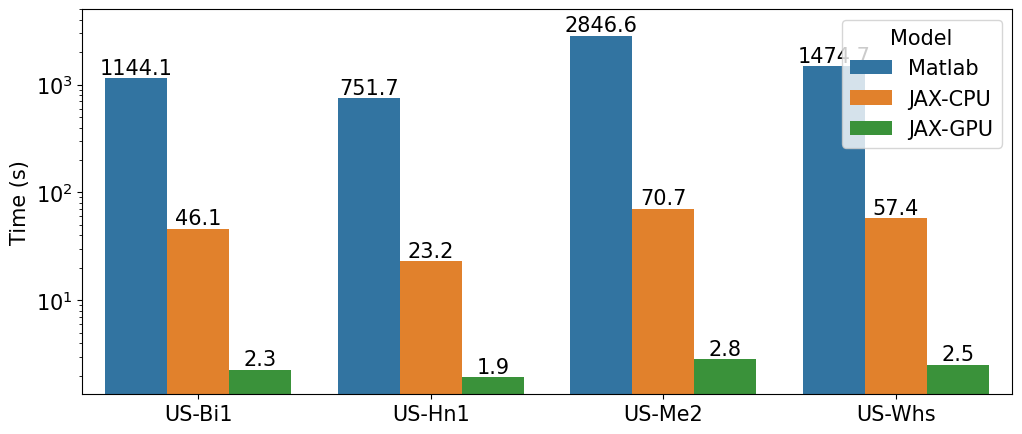

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(12,5))
sns.barplot(compute_time_df, x="Site", y="Time", hue="Model", ax=ax)
ax.set(yscale='log', ylabel='Time (s)', xlabel='', ylim=[None, 5000]);
for i in ax.containers:
    ax.bar_label(i,fmt='%.1f')
    

# Hybrid modeling vs process-based modeling

In [123]:
def filter_metric(
    df_metrics,
    site=None,
    model=None,
    layer=None,
    weight=None,
    varn=None,
    train_or_test=None,
):
    conditions = []
    if site is not None:
        conditions.append(df_metrics["site"] == site)
    if model is not None:
        model = [model] if isinstance(model, str) else model
        conditions.append(df_metrics["model"].isin(model))
    if layer is not None:
        layer = [layer] if isinstance(layer, str) else layer
        conditions.append(df_metrics["layer"].isin(layer))
    if weight is not None:
        # conditions.append(df_metrics["weight"] == weight)
        weight = [weight] if isinstance(weight, float) else weight
        conditions.append(df_metrics["weight"].isin(weight))
    if varn is not None:
        conditions.append(df_metrics["varn"] == varn)
    if train_or_test is not None:
        conditions.append(df_metrics["train_or_test"] == train_or_test)
    and_condition = conditions[0]
    for condition in conditions:
        and_condition &= condition
    return df_metrics[and_condition]

/tmp/ipykernel_821547/1758214611.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=15)
/tmp/ipykernel_821547/1758214611.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=15)
/tmp/ipykernel_821547/1758214611.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=15)
/tmp/ipykernel_821547/1758214611.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=15)
/tmp/ipykernel_821547/1758214611.py:14: UserWarning: set_ticklabels() should only be used with a fixed n

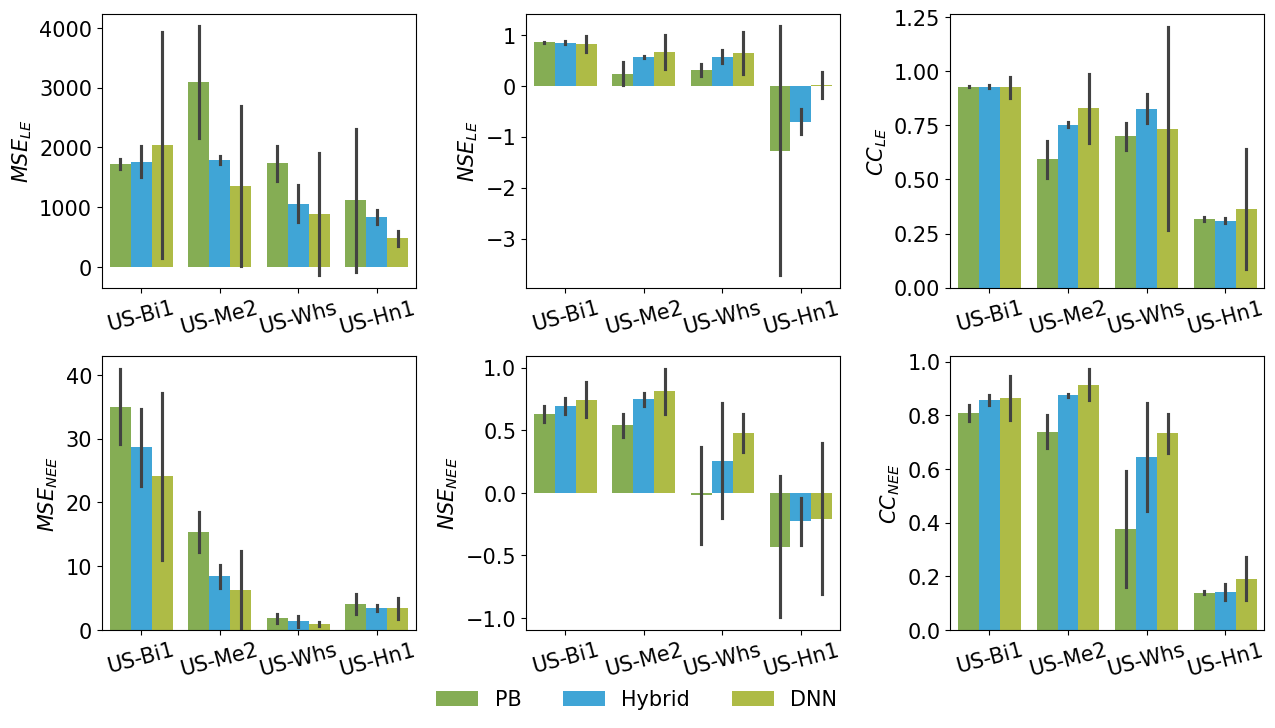

In [78]:
train_or_test, layer = "test", ["ML", "DNN"]
fig, axes = plt.subplots(2, len(metrics), figsize=(15, 8))
for i, varn in enumerate(["LE", "NEE"]):
    for j, metric in enumerate(metrics):
        ax = axes[i, j]
        df_metrics_sub = filter_metric(
            df_metrics, layer=layer, varn=varn, train_or_test=train_or_test
        )
        ax = sns.barplot(df_metrics_sub, ax=ax, x="site", y=metric, hue="model", errorbar='sd',
                         palette=['#87bc45', '#27aeef', '#bdcf32'], 
                         legend="full" if i==1 and j==len(metrics)-1 else False)
        ax.set(xlabel="", ylabel=f"${metric.upper()}_{'{'+varn+'}'}$",
               yscale="symlog" if (varn=="NEE") and (metric=="mkge") else "linear")
        ax.set_xticklabels(ax.get_xticklabels(), rotation=15)
        if i==1 and j==len(metrics)-1:
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(handles, labels, ncols=3, frameon=False, bbox_to_anchor=(-.3, -0.15), title="")
plt.subplots_adjust(wspace=0.35, hspace=0.25)


# Multilayer canopy model vs single layer canopy model

In [78]:
# train_or_test, model = "test", ["PB", "DNN"]
# fig, axes = plt.subplots(len(outputs), len(metrics), figsize=(15, 8))
# for i, varn in enumerate(outputs):
#     for j, metric in enumerate(metrics):
#         ax = axes[i, j]
#         df_metrics_sub = filter_metric(
#             df_metrics, model=model, varn=varn, train_or_test=train_or_test
#         )
#         sns.barplot(df_metrics_sub, ax=ax, x="site", y=metric, hue="layer", legend=True)
#         ax.set(xlabel="", ylabel=metric.upper(), title=varn)

/tmp/ipykernel_821547/4080787286.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=15)
/tmp/ipykernel_821547/4080787286.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=15)
/tmp/ipykernel_821547/4080787286.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=15)
/tmp/ipykernel_821547/4080787286.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=15)
/tmp/ipykernel_821547/4080787286.py:12: UserWarning: set_ticklabels() should only be used with a fixed n

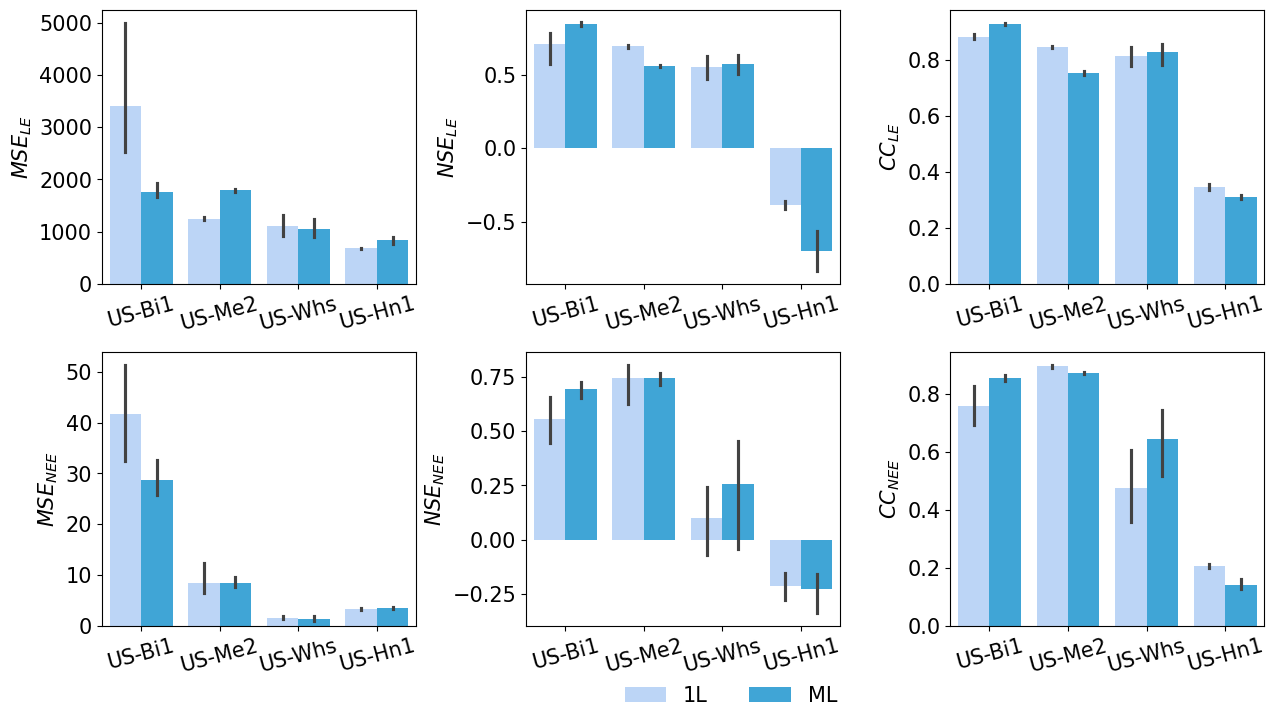

In [77]:
train_or_test, model = "test", ["Hybrid"]
fig, axes = plt.subplots(len(outputs), len(metrics), figsize=(15, 8))
for i, varn in enumerate(outputs):
    for j, metric in enumerate(metrics):
        ax = axes[i, j]
        df_metrics_sub = filter_metric(
            df_metrics, model=model, varn=varn, train_or_test=train_or_test,
        )
        sns.barplot(df_metrics_sub, ax=ax, x="site", y=metric, hue="layer", 
                    palette=['#b3d4ff', '#27aeef'], legend="full" if i==len(outputs)-1 and j==len(metrics)-1 else False)
        ax.set(xlabel="", ylabel=f"${metric.upper()}_{'{'+varn+'}'}$")
        ax.set_xticklabels(ax.get_xticklabels(), rotation=15)
        if i==len(outputs)-1 and j==len(metrics)-1:
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(handles, labels, ncols=3, frameon=False, bbox_to_anchor=(-.3, -0.15), title="")
plt.subplots_adjust(wspace=0.35, hspace=0.25)


# Pareto Front curve (multi-objective optimization)

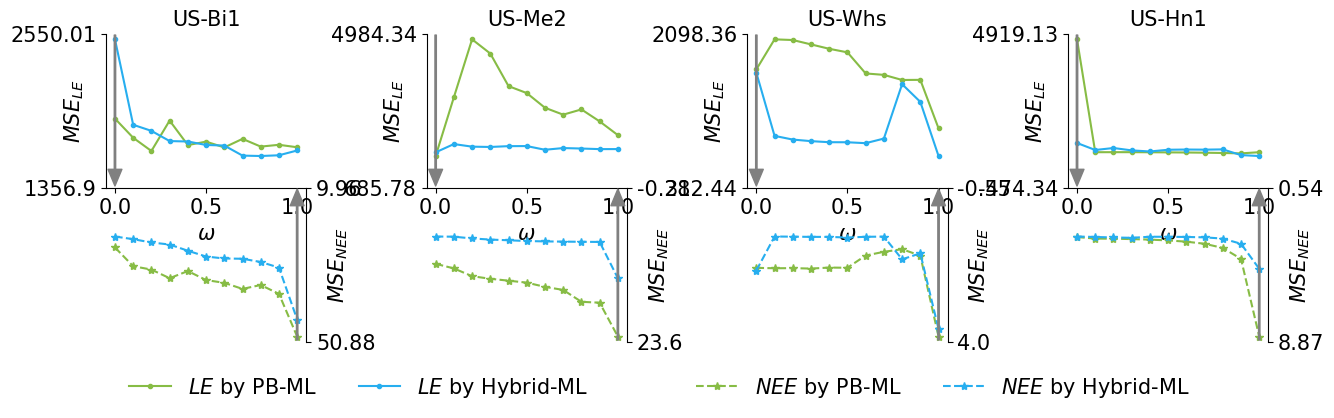

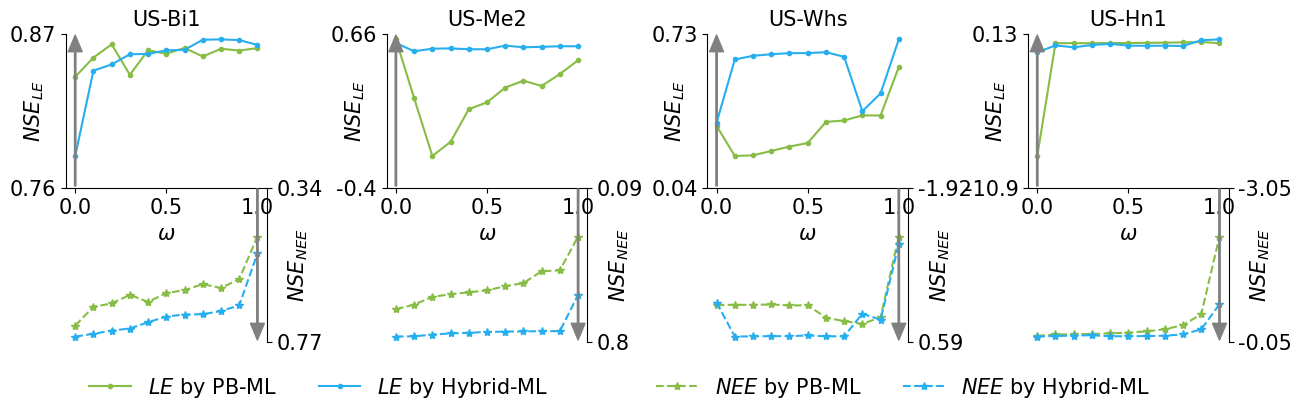

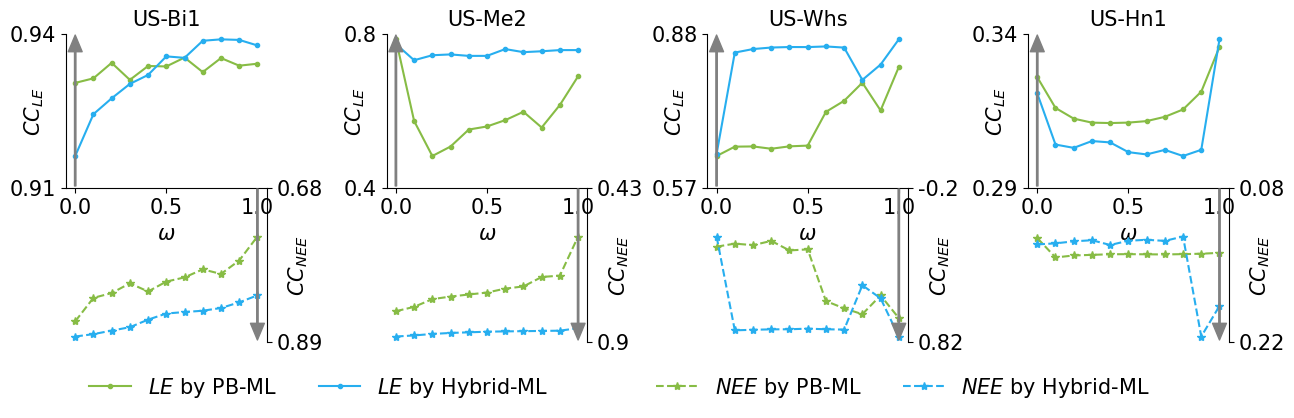

In [84]:
train_or_test, layer = "test", "ML"
for i, metric in enumerate(metrics):
    fig, axes = plt.subplots(1, len(sites), figsize=(15, 4))
    for j, site in enumerate(sites):
        ax = axes[j]
        # Process-based
        le_m = filter_metric(
            df_metrics,
            site=site,
            varn="LE",
            model="PB",
            layer=layer,
            train_or_test=train_or_test,
        )[metric]
        nee_m = filter_metric(
            df_metrics,
            site=site,
            varn="NEE",
            model="PB",
            layer=layer,
            train_or_test=train_or_test,
        )[metric]
        # Hybrid
        le_hm = filter_metric(
            df_metrics,
            site=site,
            varn="LE",
            model="Hybrid",
            layer=layer,
            train_or_test=train_or_test,
        )[metric]
        nee_hm = filter_metric(
            df_metrics,
            site=site,
            varn="NEE",
            model="Hybrid",
            layer=layer,
            train_or_test=train_or_test,
        )[metric]
        # DNN
        le_dm = filter_metric(
            df_metrics,
            site=site,
            varn="LE",
            model="DNN",
            layer="DNN",
            train_or_test=train_or_test,
        )[metric]
        nee_dm = filter_metric(
            df_metrics,
            site=site,
            varn="NEE",
            model="DNN",
            layer="DNN",
            train_or_test=train_or_test,
        )[metric]
        
        ax.plot(le_weight, le_m, ".-", color='#87bc45', label=f"$LE$ by PB-{layer}")
        ax.plot(le_weight, le_hm, ".-", color='#27aeef', label=f"$LE$ by Hybrid-{layer}")
        # ax.plot(le_weight, le_dm, ".-", label=f"DNN-{layer}")
        # ax.legend()
        
        ax2 = ax.twinx()
        ax2.plot(le_weight, nee_m, "*--", color='#87bc45', label=f"$NEE$ by PB-{layer}")
        ax2.plot(le_weight, nee_hm, "*--", color='#27aeef', label=f"$NEE$ by Hybrid-{layer}")
        # ax2.plot(le_weight, nee_dm, "*--", label=f"DNN-{layer}")
        # ax2.legend()
        
        # Make the plot more beautiful
        yrange = ax.get_ylim()
        ymid, yhigh = yrange[0], yrange[1]
        ydiff = yhigh - ymid
        ymid = ymid - ydiff * 0.2
        ymin, ymax = ymid - ydiff*1.2, ymid + ydiff*1.2
        ymid = (ymin+ymax) / 2
        ax.spines['bottom'].set_position(('data', ymid))
        ax.spines[['right', 'top']].set_visible(False)
        ax.spines['left'].set_bounds((ymid, ymax))
        ax.set(yticks=[ymid, yhigh], ylim=[ymin, ymax], 
               yticklabels=[round(ymid,2), round(yhigh,2)])
        ax.set(title=site, ylabel=f"${metric.upper()}$" + "$_{LE}$", xlabel='$\omega$')
        ax.yaxis.set_label_coords(-0.1, .75)
        ax.annotate('', xy=(0.,yhigh) if metric.lower()!='mse' else (0.,ymid), 
                    xytext=(0.,ymid) if metric.lower()!='mse' else (0.,yhigh),  
                    arrowprops=dict(color='grey', shrink=0.01, width=1, headwidth=10),)

        # Make the plot more beautiful
        yrange = ax2.get_ylim()
        ymid, yhigh = yrange[0], yrange[1]
        ydiff = yhigh - ymid
        ymid = ymid - ydiff * 0.4
        ymin, ymax = ymid - ydiff*1.4, ymid + ydiff*1.4
        ymid = (ymin+ymax) / 2
        # ymin, ymax = round(ymin,1), round(ymax,1)
        # ymid, ylow, yhigh = round((ymin+ymax)/2,1),round(ylow,1),round(yhigh,1)
        ax2.invert_yaxis()
        ax2.spines[['bottom', 'top', 'left']].set_visible(False)
        ax2.spines['right'].set_bounds((ymid, ymax))
        ax2.set(yticks=[ymid, yhigh], ylim=[ymax, ymin], 
               yticklabels=[round(ymid,2), round(yhigh,2)])
        ax2.set(ylabel=f"${metric.upper()}$" + "$_{NEE}$")
        ax2.yaxis.set_label_coords(1.1, .25)
        ax2.annotate('', xy=(1.,yhigh) if metric.lower()!='mse' else (1.,ymid), 
                    xytext=(1.,ymid) if metric.lower()!='mse' else (1.,yhigh), 
                    arrowprops=dict(color='grey', shrink=0.01, width=1, headwidth=10))
        
        if j == 0: # Put legend
            # Create a proxy artist to represent the annotation in the legend
            ax.legend(bbox_to_anchor=[2.5, -0.05], ncol=2, frameon=False)
            ax2.legend(bbox_to_anchor=[5.5, -0.05], ncol=2, frameon=False)
            # annotation_proxy = mlines.Line2D([], [], color='grey', marker='', label='better performance')
            # plt.legend(handles=[annotation_proxy])

    plt.subplots_adjust(wspace=0.6, hspace=0.6);


In [147]:
# train_or_test, layer = "test", "ML"
# fig, axes = plt.subplots(len(metrics), len(sites), figsize=(20, 12))
# for j, site in enumerate(sites):
#     for i, metric in enumerate(metrics):
#         ax = axes[i, j]
#         # Process-based
#         le_m = filter_metric(
#             df_metrics,
#             site=site,
#             varn="LE",
#             model="PB",
#             layer=layer,
#             train_or_test=train_or_test,
#         )[metric]
#         nee_m = filter_metric(
#             df_metrics,
#             site=site,
#             varn="NEE",
#             model="PB",
#             layer=layer,
#             train_or_test=train_or_test,
#         )[metric]
#         # ax.scatter(le_m, nee_m, label='PB-1L')
#         ax.plot(le_m, nee_m, "*-", label=f"PB-{layer}")

#         # Hybrid
#         le_m = filter_metric(
#             df_metrics,
#             site=site,
#             varn="LE",
#             model="Hybrid",
#             layer=layer,
#             train_or_test=train_or_test,
#         )[metric]
#         nee_m = filter_metric(
#             df_metrics,
#             site=site,
#             varn="NEE",
#             model="Hybrid",
#             layer=layer,
#             train_or_test=train_or_test,
#         )[metric]
#         # ax.scatter(le_m, nee_m, label='Hybrid-1L')
#         ax.plot(le_m, nee_m, "*-", label=f"Hybrid-{layer}")

#         # DNN
#         le_m = filter_metric(
#             df_metrics,
#             site=site,
#             varn="LE",
#             model="DNN",
#             layer="DNN",
#             train_or_test=train_or_test,
#         )[metric]
#         nee_m = filter_metric(
#             df_metrics,
#             site=site,
#             varn="NEE",
#             model="DNN",
#             layer="DNN",
#             train_or_test=train_or_test,
#         )[metric]
#         # ax.scatter(le_m, nee_m, label='DNN')
#         ax.legend()

#         ax.set(
#             xlabel=f"{metric.upper()}-LE",
#             ylabel=f"{metric.upper()}-NEE",
#             title=site if i == 0 else "",
#         )

# Time series plot

## Diurnal signal

In [31]:
def convert_to_24hr(df):
    df = df.resample("30T").mean()
    df["Time_of_Day"] = df.index.time
    # Pivot to get the average value for each 30-minute interval across 24-hour periods
    return df.groupby("Time_of_Day").mean()

In [294]:
# fig, ax = plt.subplots(1, 1, figsize=(12,5))
# df_simulations_set["US-Me2-test"]['Hybrid-ML-0.5']['gs'].plot(ax=ax)
# df_simulations_set["US-Me2-test"]['PB-ML-0.5']['gs'].plot(ax=ax, alpha=0.5)
# ax2 = ax.twinx()
# df_simulations_set["US-Me2-test"]['Hybrid-ML-0.5']['SWC-obs'].plot(ax=ax2, color='black')


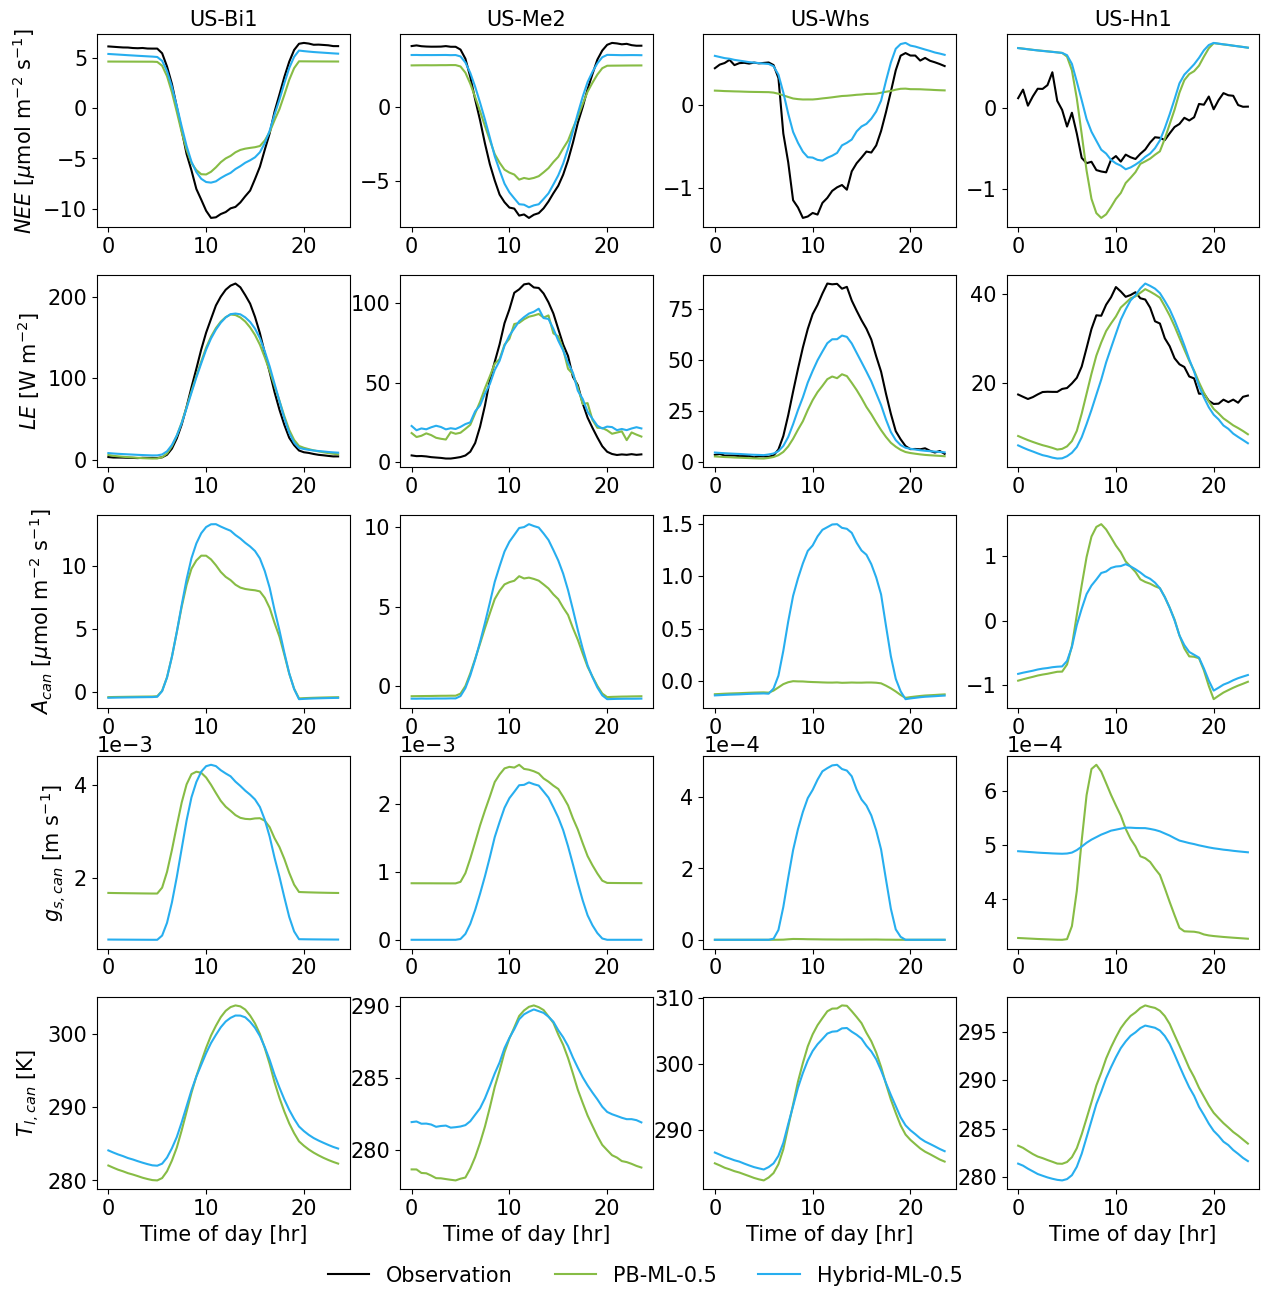

In [49]:
train_or_test, layer, weight = "test", "ML", "0.5"

fig, axes = plt.subplots(5, 4, figsize=(15, 15))
for i,site in enumerate(sites):
    df = df_simulations_set[f"{site}-{train_or_test}"]
    pb = convert_to_24hr(df[f"PB-{layer}-{weight}"])
    hybrid = convert_to_24hr(df[f"Hybrid-{layer}-{weight}"])
    pb.index = pb.index.map(lambda x: x.hour+x.minute/60.)
    hybrid.index = hybrid.index.map(lambda x: x.hour+x.minute/60.)
    # dnn = convert_to_24hr(df[f'DNN_LE-GPP-{weight}'])
    
    ax1 = axes[1,i]
    pb["LE-obs"].plot(ax=ax1, color='black', label="Observation")
    pb["LE"].plot(ax=ax1, color='#87bc45', label=f"PB-{layer}-{weight}")
    hybrid["LE"].plot(ax=ax1, color='#27aeef', label=f"Hybrid-{layer}-{weight}")
    ax1.set(ylabel="$LE$ [W m$^{-2}$]"  if i==0 else None, xlabel='')

    ax2 = axes[0,i]
    pb["NEE-obs"].plot(ax=ax2, color='black', label="Observation")
    pb["NEE"].plot(ax=ax2, color='#87bc45', label=f"PB-{layer}-{weight}")
    hybrid["NEE"].plot(ax=ax2, color='#27aeef', label=f"Hybrid-{layer}-{weight}")
    ax2.set(title=site, ylabel="$NEE$ [$\mu$mol m$^{-2}$ s$^{-1}$]" if i==0 else None, xlabel='')
    # ax.legend()
    
    ax = axes[2,i]
    pb["Ps"].plot(ax=ax, color='#87bc45', label=f"PB-{layer}-{weight}")
    hybrid["Ps"].plot(ax=ax, color='#27aeef', label=f"Hybrid-{layer}-{weight}")
    ax.set(ylabel="$A_{can}$ [$\mu$mol m$^{-2}$ s$^{-1}$]" if i==0 else None, xlabel='')

    ax = axes[3,i]
    pb["gs"].plot(ax=ax, color='#87bc45', label=f"PB-{layer}-{weight}")
    hybrid["gs"].plot(ax=ax, color='#27aeef', label=f"Hybrid-{layer}-{weight}")
    ax.set(ylabel="$g_{s,can}$ [m s$^{-1}$]" if i==0 else None, xlabel='')
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    # ax2 = ax.twinx()
    # pb["SWC-obs"].plot(ax=ax2, color='blue', label=f"PB-{layer}-{weight}")
    
    ax = axes[4,i]
    pb["Tsfc"].plot(ax=ax, color='#87bc45', label=f"PB-{layer}-{weight}")
    hybrid["Tsfc"].plot(ax=ax, color='#27aeef', label=f"Hybrid-{layer}-{weight}")
    ax.set(ylabel="$T_{l,can}$ [K]" if i==0 else None, xlabel='Time of day [hr]')
    # ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    
    if i == 0:
        ax2.legend(bbox_to_anchor=[3.5, -5.3], ncol=3, frameon=False)

plt.subplots_adjust(hspace=0.25)


## Full time series

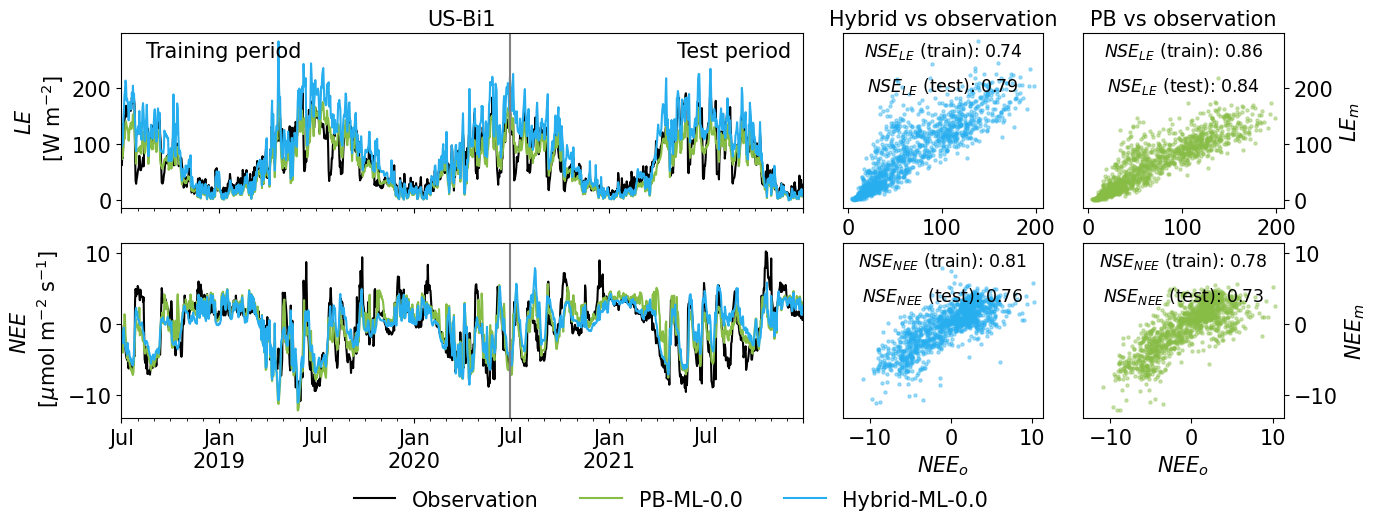

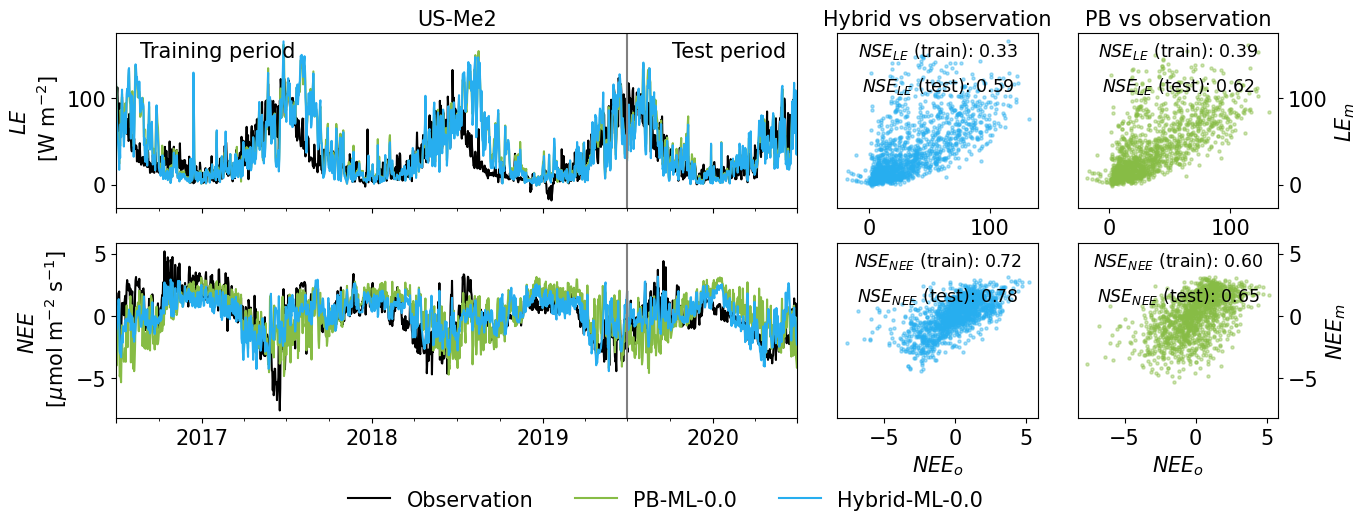

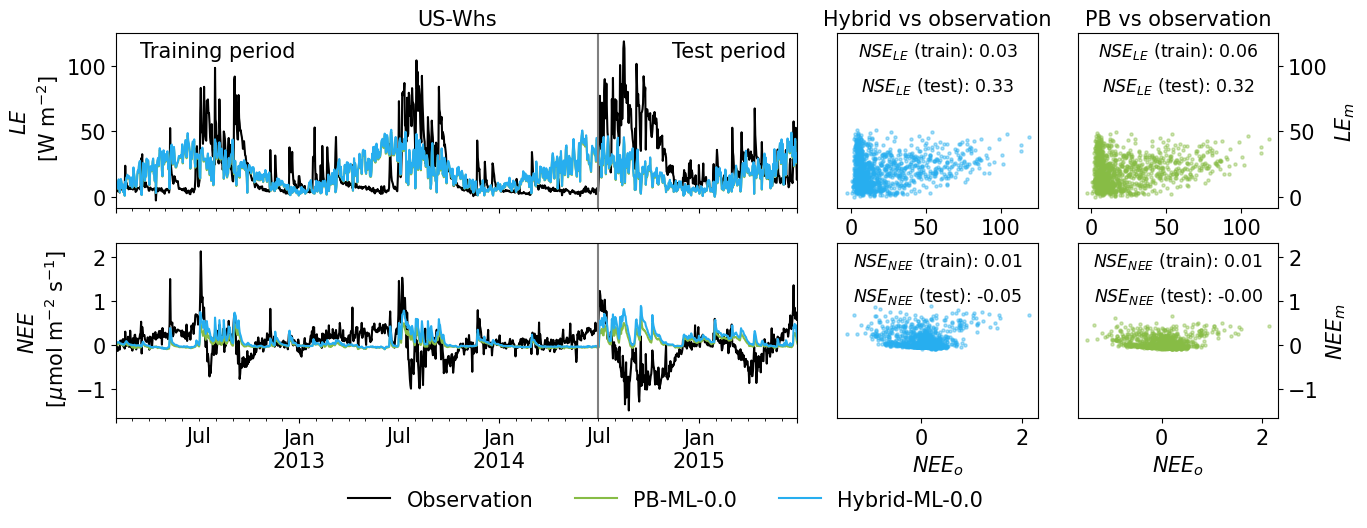

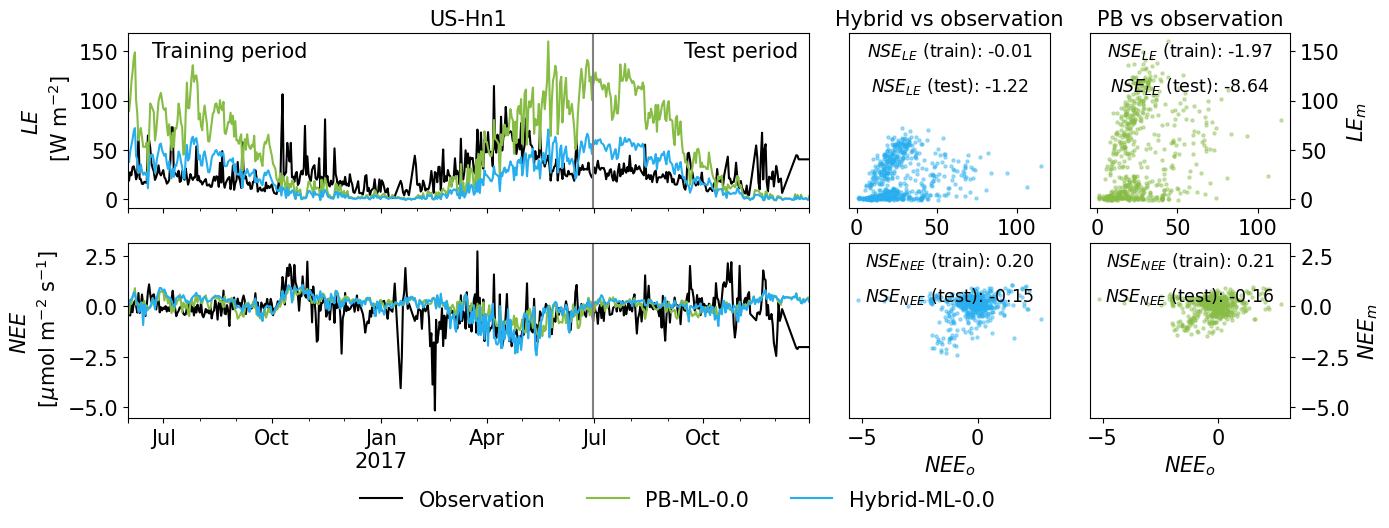

In [144]:
weight = "0.0"
for site,layer in itertools.product(sites, ['ML']):
    # Train data
    train_pb = (
        df_simulations_set[f"{site}-train"][f"PB-{layer}-{weight}"].resample("D").mean()
    )
    train_hybrid = (
        df_simulations_set[f"{site}-train"][f"Hybrid-{layer}-{weight}"]
        .resample("D")
        .mean()
    )
    # train_dnn = df_simulations_set[f"{site}-train"][f'DNN_LE-GPP-{weight}']

    # test data
    test_pb = (
        df_simulations_set[f"{site}-test"][f"PB-{layer}-{weight}"].resample("D").mean()
    )
    test_hybrid = (
        df_simulations_set[f"{site}-test"][f"Hybrid-{layer}-{weight}"]
        .resample("D")
        .mean()
    )
    # test_dnn = df_simulations_set[f"{site}-test"][f'DNN_LE-GPP-{weight}']
    train_test_split = train_hybrid.index[-1]

    pb = pd.concat([train_pb, test_pb])
    hybrid = pd.concat([train_hybrid, test_hybrid])

    # fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    fig = plt.figure(figsize=(15, 5))
    gs = GridSpec(2, 5, figure=fig)
    ax1 = fig.add_subplot(gs[0,:-2])
    pb["LE-obs"].plot(ax=ax1, color='black', label="Observation")
    pb["LE"].plot(ax=ax1, color='#87bc45', label=f"PB-{layer}-{weight}")
    hybrid["LE"].plot(ax=ax1, color='#27aeef', label=f"Hybrid-{layer}-{weight}")
    ax1.axvline(x=train_test_split, color="grey")
    ax1.text(0.15, .9, 'Training period', transform=ax1.transAxes, ha='center', va='center')
    ax1.text(0.9, .9, 'Test period', transform=ax1.transAxes, ha='center', va='center')
    # ax1.legend()
    ax1.set(ylabel="$LE$ \n [W m$^{-2}$]", title=site)
    
    ax1b = fig.add_subplot(gs[0,-2])
    ax1b.scatter(pb["LE-obs"], hybrid["LE"], color='#27aeef', alpha=0.4, s=5)
    metric_train = filter_metric(
        df_metrics, site=site, layer=layer, weight=float(weight), 
        varn='LE', model='Hybrid', train_or_test='train'
    )['nse'].values[0]
    metric_test = filter_metric(
        df_metrics, site=site, layer=layer, weight=float(weight), 
        varn='LE', model='Hybrid', train_or_test='test'
    )['nse'].values[0]
    ax1b.text(0.5, .9, '$NSE_{LE}$ (train): '+f"{metric_train:.2f}", 
              transform=ax1b.transAxes, ha='center', va='center', size='small')
    ax1b.text(0.5, .7, '$NSE_{LE}$ (test): '+f"{metric_test:.2f}", 
              transform=ax1b.transAxes, ha='center', va='center', size='small')
    ax1b.set(xlabel='$LE_o$', yticks=[], ylim=ax1.get_ylim(), title=f"Hybrid vs observation")
    
    ax1c = fig.add_subplot(gs[0,-1])
    ax1c.scatter(pb["LE-obs"], pb["LE"], color='#87bc45', alpha=0.4, s=5)
    metric_train = filter_metric(
        df_metrics, site=site, layer=layer, weight=float(weight), 
        varn='LE', model='PB', train_or_test='train'
    )['nse'].values[0]
    metric_test = filter_metric(
        df_metrics, site=site, layer=layer, weight=float(weight), 
        varn='LE', model='PB', train_or_test='test'
    )['nse'].values[0]
    ax1c.text(0.5, .9, '$NSE_{LE}$ (train): '+f"{metric_train:.2f}", 
              transform=ax1c.transAxes, ha='center', va='center', size='small')
    ax1c.text(0.5, .7, '$NSE_{LE}$ (test): '+f"{metric_test:.2f}", 
              transform=ax1c.transAxes, ha='center', va='center', size='small')
    ax1c.yaxis.tick_right()
    ax1c.yaxis.set_label_position("right")
    ax1c.set(xlabel='$LE_o$', ylabel=f"$LE_m$", ylim=ax1b.get_ylim(), title=f"PB vs observation")

    ax2 = fig.add_subplot(gs[1,:-2], sharex=ax1)
    pb["NEE-obs"].plot(ax=ax2, color='black', label="Observation")
    pb["NEE"].plot(ax=ax2, color='#87bc45', label=f"PB-{layer}-{weight}")
    hybrid["NEE"].plot(ax=ax2, color='#27aeef', label=f"Hybrid-{layer}-{weight}")
    ax2.axvline(x=train_test_split, color="grey")
    ax2.yaxis.tick_left()
    ax2.legend(bbox_to_anchor=[1.3, -0.3], ncol=3, frameon=False)
    ax2.set(ylabel="$NEE$ \n [$\mu$mol m$^{-2}$ s$^{-1}$]")
    
    ax2b = fig.add_subplot(gs[1,-2])
    ax2b.scatter(pb["NEE-obs"], hybrid["NEE"], color='#27aeef', alpha=0.4, s=5)
    metric_train = filter_metric(
        df_metrics, site=site, layer=layer, weight=float(weight), 
        varn='NEE', model='Hybrid', train_or_test='train'
    )['nse'].values[0]
    metric_test = filter_metric(
        df_metrics, site=site, layer=layer, weight=float(weight), 
        varn='NEE', model='Hybrid', train_or_test='test'
    )['nse'].values[0]
    ax2b.text(0.5, .9, '$NSE_{NEE}$ (train): '+f"{metric_train:.2f}", 
              transform=ax2b.transAxes, ha='center', va='center', size='small')
    ax2b.text(0.5, .7, '$NSE_{NEE}$ (test): '+f"{metric_test:.2f}", 
              transform=ax2b.transAxes, ha='center', va='center', size='small')
    ax2b.set(xlabel='$NEE_o$', yticks=[], xlim=ax2.get_ylim(), ylim=ax2.get_ylim())
    
    ax2c = fig.add_subplot(gs[1,-1])
    ax2c.scatter(pb["NEE-obs"], pb["NEE"], color='#87bc45', alpha=0.4, s=5)
    # ax2c.set(xlabel='Observation', ylabel=f"PB-{layer}-{weight}")
    metric_train = filter_metric(
        df_metrics, site=site, layer=layer, weight=float(weight), 
        varn='NEE', model='PB', train_or_test='train'
    )['nse'].values[0]
    metric_test = filter_metric(
        df_metrics, site=site, layer=layer, weight=float(weight), 
        varn='NEE', model='PB', train_or_test='test'
    )['nse'].values[0]
    ax2c.text(0.5, .9, '$NSE_{NEE}$ (train): '+f"{metric_train:.2f}", 
              transform=ax2c.transAxes, ha='center', va='center', size='small')
    ax2c.text(0.5, .7, '$NSE_{NEE}$ (test): '+f"{metric_test:.2f}", 
              transform=ax2c.transAxes, ha='center', va='center', size='small')
    ax2c.yaxis.tick_right()
    ax2c.yaxis.set_label_position("right")
    ax2c.set(xlabel='$NEE_o$', ylabel=f"$NEE_m$", xlim=ax2.get_ylim(), ylim=ax2.get_ylim())
